In [2]:
 import zipfile
import os

zip_path = "/content/archive.zip"  # ✅ Update if stored elsewhere
extract_path = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Optional: check contents
os.listdir(extract_path)

['Testing', 'Training']

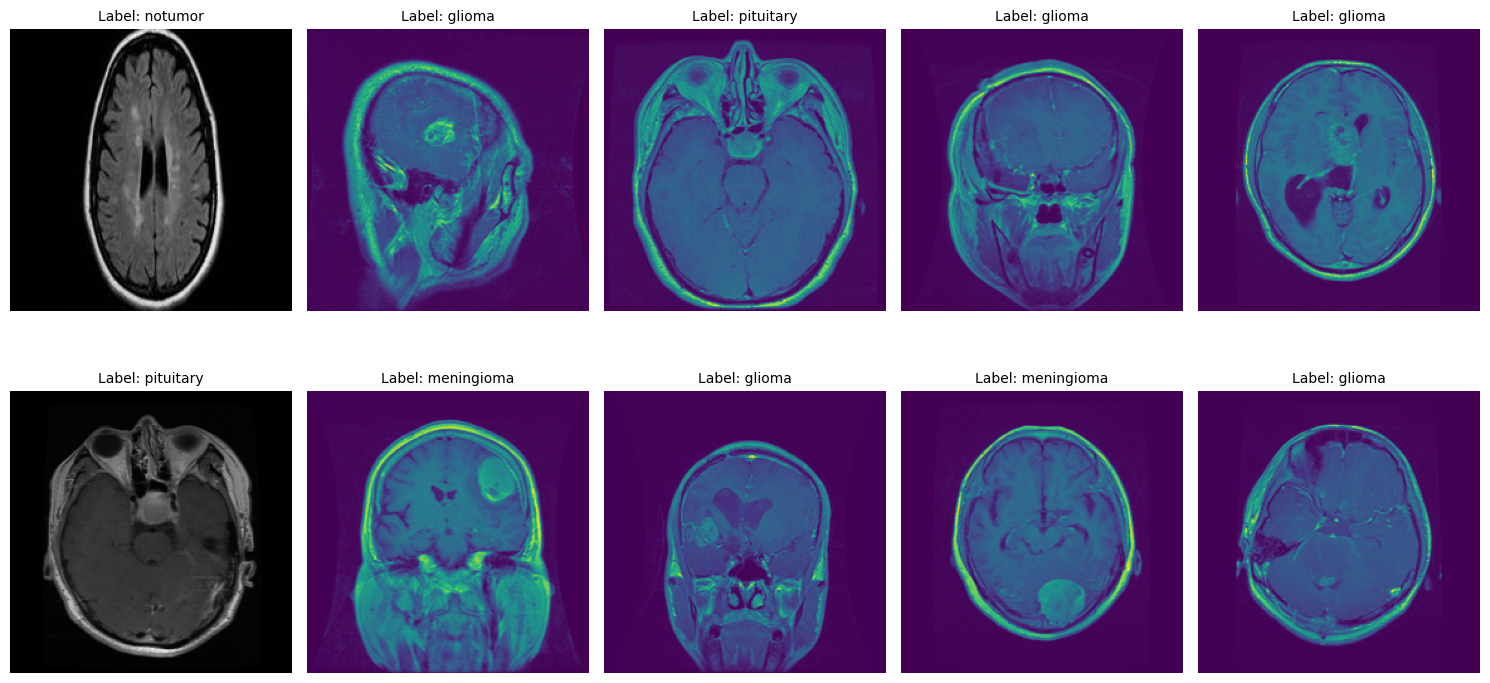

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 887s 3s/step - loss: 0.6120 - sparse_categorical_accuracy: 0.7618
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 906s 3s/step - loss: 0.2677 - sparse_categorical_accuracy: 0.8973
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 973s 3s/step - loss: 0.1665 - sparse_categorical_accuracy: 0.9330
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 943s 3s/step - loss: 0.1410 - sparse_categorical_accuracy: 0.9464
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 915s 3s/step - loss: 0.0994 - sparse_categorical_accuracy: 0.9589


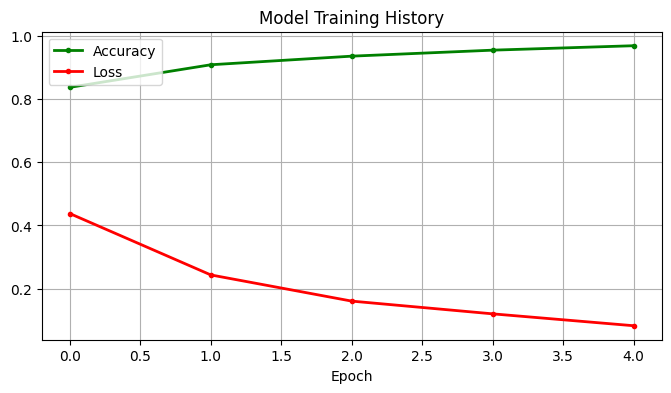

41/41 ━━━━━━━━━━━━━━━━━━━━ 165s 4s/step
Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.88      0.93       300
  meningioma       0.89      0.97      0.93       306
     notumor       1.00      0.99      0.99       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



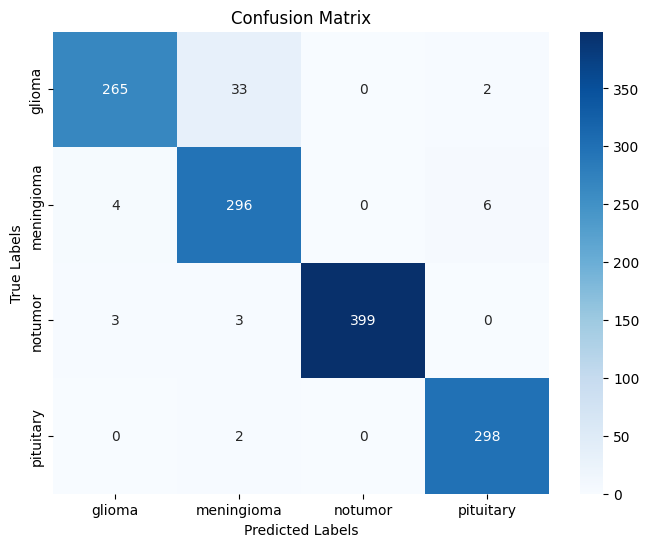

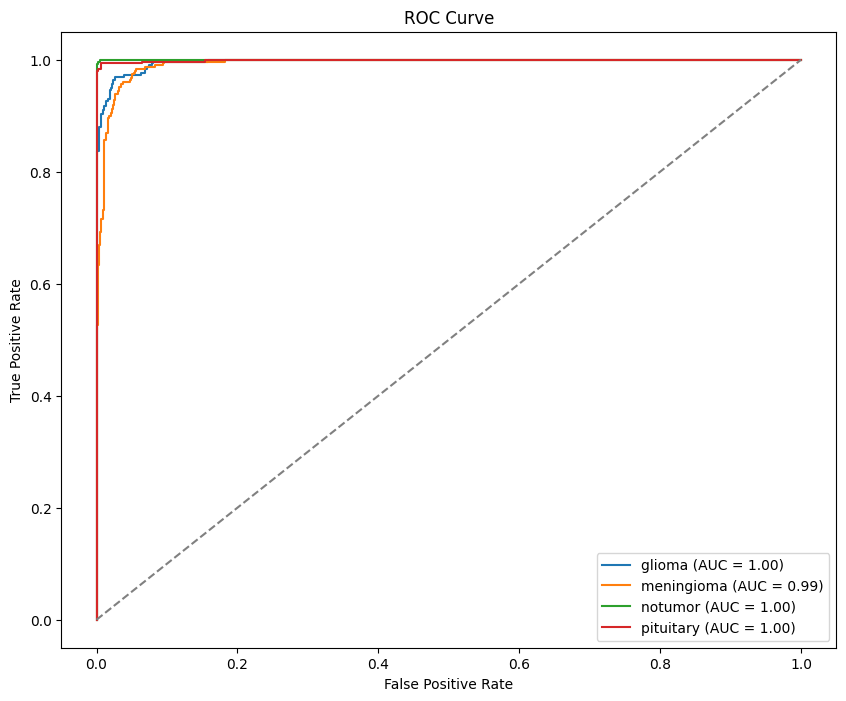

Error processing the image: [Errno 2] No such file or directory: '/content/drive/MyDrive/MRI Images/Testing/meningioma/Te-meTr_0001.jpg'


In [3]:
# === 2. Import Dependencies ===
import os
import random
import numpy as np
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# === 3. Set Dataset Paths (UPDATE THESE) ===
train_dir = '/content/dataset/Training'   # <-- Update after uploading
test_dir = '/content/dataset/Testing'     # <-- Update after uploading

# === 4. Constants ===
IMAGE_SIZE = 128
BATCH_SIZE = 20
EPOCHS = 5
CLASS_LABELS = sorted(os.listdir(train_dir))

# === 5. Load and Shuffle Data Paths ===
def load_paths_labels(directory):
    paths, labels = [], []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        for image in os.listdir(label_dir):
            paths.append(os.path.join(label_dir, image))
            labels.append(label)
    return shuffle(paths, labels)

train_paths, train_labels = load_paths_labels(train_dir)
test_paths, test_labels = load_paths_labels(test_dir)

# === 6. Visualize Sample Images ===
random_indices = random.sample(range(len(train_paths)), 10)
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    img = Image.open(train_paths[idx]).resize((224, 224))
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)
plt.tight_layout()
plt.show()

# === 7. Augmentation & Loading ===
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    return np.array(image) / 255.0

def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = img_to_array(image)
        image = augment_image(image)
        images.append(image)
    return np.array(images)

def encode_label(labels):
    return np.array([CLASS_LABELS.index(label) for label in labels])

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = encode_label(labels[i:i + batch_size])
            yield batch_images, batch_labels

# === 8. Build Model Using VGG16 ===
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(CLASS_LABELS), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# === 9. Train Model ===
steps_per_epoch = len(train_paths) // BATCH_SIZE
history = model.fit(datagen(train_paths, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS),
                    epochs=EPOCHS, steps_per_epoch=steps_per_epoch)

# === 10. Plot Accuracy and Loss ===
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.show()

# === 11. Evaluate on Test Data ===
test_images = open_images(test_paths)
test_labels_encoded = encode_label(test_labels)
test_predictions = model.predict(test_images)

# Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1), target_names=CLASS_LABELS))

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# ROC Curve
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(CLASS_LABELS)))
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(CLASS_LABELS)):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(len(CLASS_LABELS)):
    plt.plot(fpr[i], tpr[i], label=f'{CLASS_LABELS[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# === 12. Save the Model ===
model.save('model.h5')

# === 13. Predict on New Image ===
def detect_and_display(img_path, model, image_size=128):
    try:
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions)

        if CLASS_LABELS[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {CLASS_LABELS[predicted_class_index]}"

        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()
    except Exception as e:
        print("Error processing the image:", str(e))

# === 14. Example Usage ===
# Change the path to test other images
sample_image = '/content/drive/MyDrive/MRI Images/Testing/meningioma/Te-meTr_0001.jpg'
detect_and_display(sample_image, model)

In [9]:
model.save("model.h5")
print("✅ model.h5 saved successfully")


✅ model.h5 saved successfully


In [14]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


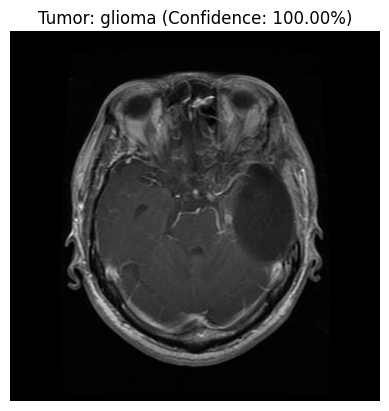

In [10]:
sample_image = '/content/Te-gl_0015.jpg'
detect_and_display(sample_image, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


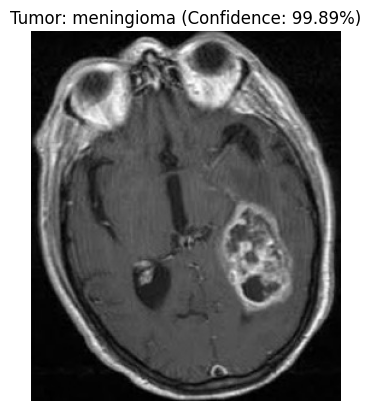

In [11]:
sample_image = '/content/Te-meTr_0001.jpg'
detect_and_display(sample_image, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


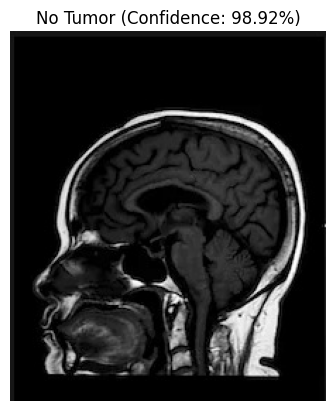

In [12]:
sample_image = '/content/Te-noTr_0004.jpg'
detect_and_display(sample_image, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


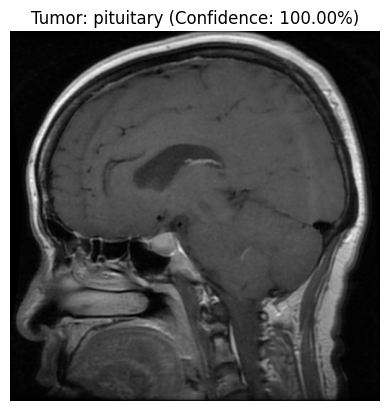

In [13]:
sample_image = '/content/Te-piTr_0003.jpg'
detect_and_display(sample_image, model)